In [9]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob

import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from matplotlib import ticker
from matplotlib.legend import Legend
from IPython.display import clear_output
from matplotlib.lines import Line2D

from utils import *
from AnalyseDefects_dev import AnalyseDefects
from AnalyseDefectsAll import AnalyseDefectsAll

plt.style.use('sg_article')


In [2]:
def plot_structure_factor(kbins, smeans, sstds, k = None, plot_scaling=False, LX = None, sf_estimated = None):
    """
    Plot structure factor
    """

    k_begin_lines_idx = 10
    kmin, kmax = np.nanmin(kbins), np.nanmax(kbins)
    sf_min, sf_max = np.nanmin(smeans), np.nanmax(smeans)
    x = np.linspace(kmin, kbins[k_begin_lines_idx], 10)

    fig, ax = plt.subplots()
    
    if k and sf_estimated:
        ax.scatter(np.linalg.norm(k, axis = 1), sf_estimated, label='Structure factor', s=2.5, alpha=0.3)

    ax.hlines(1, x[0], kmax, label=r'Possion', linestyles='dashed', colors='k')
    ax.errorbar(kbins, smeans, yerr = sstds, fmt = 's-', label = 'Binned means', alpha = .8, color = 'red', ecolor = 'black', markersize = 5)

    if plot_scaling:
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.1 / x[-1]**0.1, label=r'$k^{0.1}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.2 / x[-1]**0.2, label=r'$k^{0.2}$')
        ax.plot(x, smeans[k_begin_lines_idx] * x**0.3 /x[-1]**0.3, label=r'$k^{0.3}$')

    ax.set_xscale('log')
    ax.set_yscale('log')
 #   ax.set_xticks(np.logspace(np.log10(kmin), np.log10(kmax), 5), np.round(np.logspace(np.log10(kmin), np.log10(kmax), 5),3))   
    
 #   ax.set_ylim([sf_min/4, sf_max + 3])
  #  ax.set_xlim([kmin - 0.01, kmax + 0.1])
    ax.legend(ncol=3, fontsize = 14)
    ax.set_xlabel(r'Norm of wavenumber ($k$)')
    ax.set_ylabel(r'Time av. structure factor')

    if LX == 2048:
            ax.set_xticks([kmin, 0.01, 0.1, kmax], [np.round(kmin,3), 0.01, 0.1, np.round(kmax,1)])
            ax.set_yticks([0.3, 0.4, 0.6, 1, 5], [0.3, 0.4, 0.6, 1, 5])
    else:
        ax.set_xticks([kmin, 0.1, kmax], [np.round(kmin,3), 0.1, np.round(kmax,1)])
    #    ax.set_yticks([0.3, 0.4, 0.6, 1,], [0.3, 0.4, 0.6, 1,])

    return fig, ax


def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    priority_vl = 2 if LL == 512 else 3
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = priority_vl, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3 if priority_vl == 2 else 2, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list


def plot_alpha_mean_all(obj, use_density_fit = True, act_idx_bounds = None,):
    

    suffix = 'dens' if use_density_fit else 'count'

    fig, ax = plt.subplots(figsize=(9, 6))
    marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

    for i, LX in enumerate(obj.LX):
        act_list = obj.act_list[i]

        try:
            alpha_list = np.load(os.path.join(obj.inputs_paths[i], f'alpha_list_{suffix}.npy'))
        except:
            print('Alpha list not found. Analyse hyperuniformity first.')
            return
        try:
            alpha_list_sfac_time_av = np.load(os.path.join(obj.inputs_paths[i], f'fit_params_sfac_time_av.npy'))[:,[0,2]]
        except:
            print('Alpha list not found. Analyse sfac first.')
            return
        
        act_idx_bounds = [0, None] if act_idx_bounds is None else act_idx_bounds
        act_list = np.array(act_list[act_idx_bounds[0]:act_idx_bounds[1]])

        alpha_list_sfac_time_av = alpha_list_sfac_time_av[act_idx_bounds[0]:act_idx_bounds[1]]
        alpha_list = alpha_list[act_idx_bounds[0]:act_idx_bounds[1]]

        ax.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[0], \
                label = f'L = {obj.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')

        ax.errorbar(act_list, alpha_list_sfac_time_av[:, 0], alpha_list_sfac_time_av[:, 1], fmt = marker_shape[2], \
                        alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
        
    ax.legend()
    ax.set_xlabel(r'$\zeta$')
    ax.set_ylabel(rf'$\langle\alpha \rangle$')
    ax.set_title(rf'Time av. of $\alpha $ vs activity')
    fig.tight_layout()
    return fig, ax


def analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,8],):
    """
    returns fit_params_time_av
    """

    def fit_func(x, alpha, beta):
                return beta + alpha * x
    param_guess = np.array([0.1, 0.1])
    fit_string = rf'$y = \beta + \alpha |k|$'
    Nparams = len(param_guess)
    Nact = sfac_av.shape[1]

    fit_params_sfac_time_av = np.zeros([Nact, 2 * Nparams]) * np.nan

    for i in range(Nact):
        try:
            x = np.log(kbins)
            y = np.log(sfac_av[:, i, 0])
            yerr = sfac_av[:, i, 1] / sfac_av[:, i, 0] 
        except:
            continue

        fit_vals = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))
        fit_err = np.nan * np.zeros((Npoints_bounds[1] - Npoints_bounds[0], Nparams))

        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)
            for j, Npoints_to_fit in enumerate(range(Npoints_bounds[0], Npoints_bounds[1])):         
                
                fit = do_chi2_fit(fit_func, x[:Npoints_to_fit], y[:Npoints_to_fit], yerr[:Npoints_to_fit],
                                   param_guess, verbose = False)
                
                fit_vals[j] = fit.values[:] if fit._fmin.is_valid else [np.nan, np.nan]
                fit_err[j] = fit.errors[:] if fit._fmin.is_valid  else [np.nan, np.nan]
            nan_mask = np.isnan(fit_vals[:,0])
            fit_vals_valid = fit_vals[~nan_mask]
            fit_err_valid = fit_err[~nan_mask]
         #   print(i)
         #   print(fit_vals[:,0])
         #   print(fit_err[:,0])
            if len(fit_vals_valid) == 0 or len(fit_err_valid) == 0:
                continue
            alpha_weighted_av, alpha_sem = calc_weighted_mean(fit_vals_valid[:,0], fit_err_valid[:,0])
            beta_weighted_av, beta_sem = calc_weighted_mean(fit_vals_valid[:,1], fit_err_valid[:,1])
            alpha_std, beta_std = np.std(fit_vals_valid, axis = 0)
          #  print(alpha_weighted_av, np.nanmean(fit_vals_valid[:,0]))
           # print(alpha_sem, alpha_std / np.sqrt(fit_vals_valid.shape[0]))
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=RuntimeWarning)
            fit_params_sfac_time_av[i, :Nparams] = alpha_weighted_av, beta_weighted_av
            fit_params_sfac_time_av[i, Nparams:] = alpha_std / np.sqrt(fit_vals_valid.shape[0]), beta_std / np.sqrt(fit_vals_valid.shape[0]) #alpha_sem, beta_sem
   
    return fit_params_sfac_time_av


In [3]:
system_size_list = [256, 512,1024, 2048]
#system_size_list = [2048]
ada = AnalyseDefectsAll(system_size_list)

In [4]:
LL = 2048
output_path = f'data\\nematic_analysis{LL}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LL, mode)

ad = AnalyseDefects(defect_list, output_path=output_path)

extract = False
analyze = False
merge = False

In [5]:
len_scale_arr_path = os.path.join(ad.output_main_path, 'len_scale_arr.npy')
len_scales_arr = np.load(len_scale_arr_path)

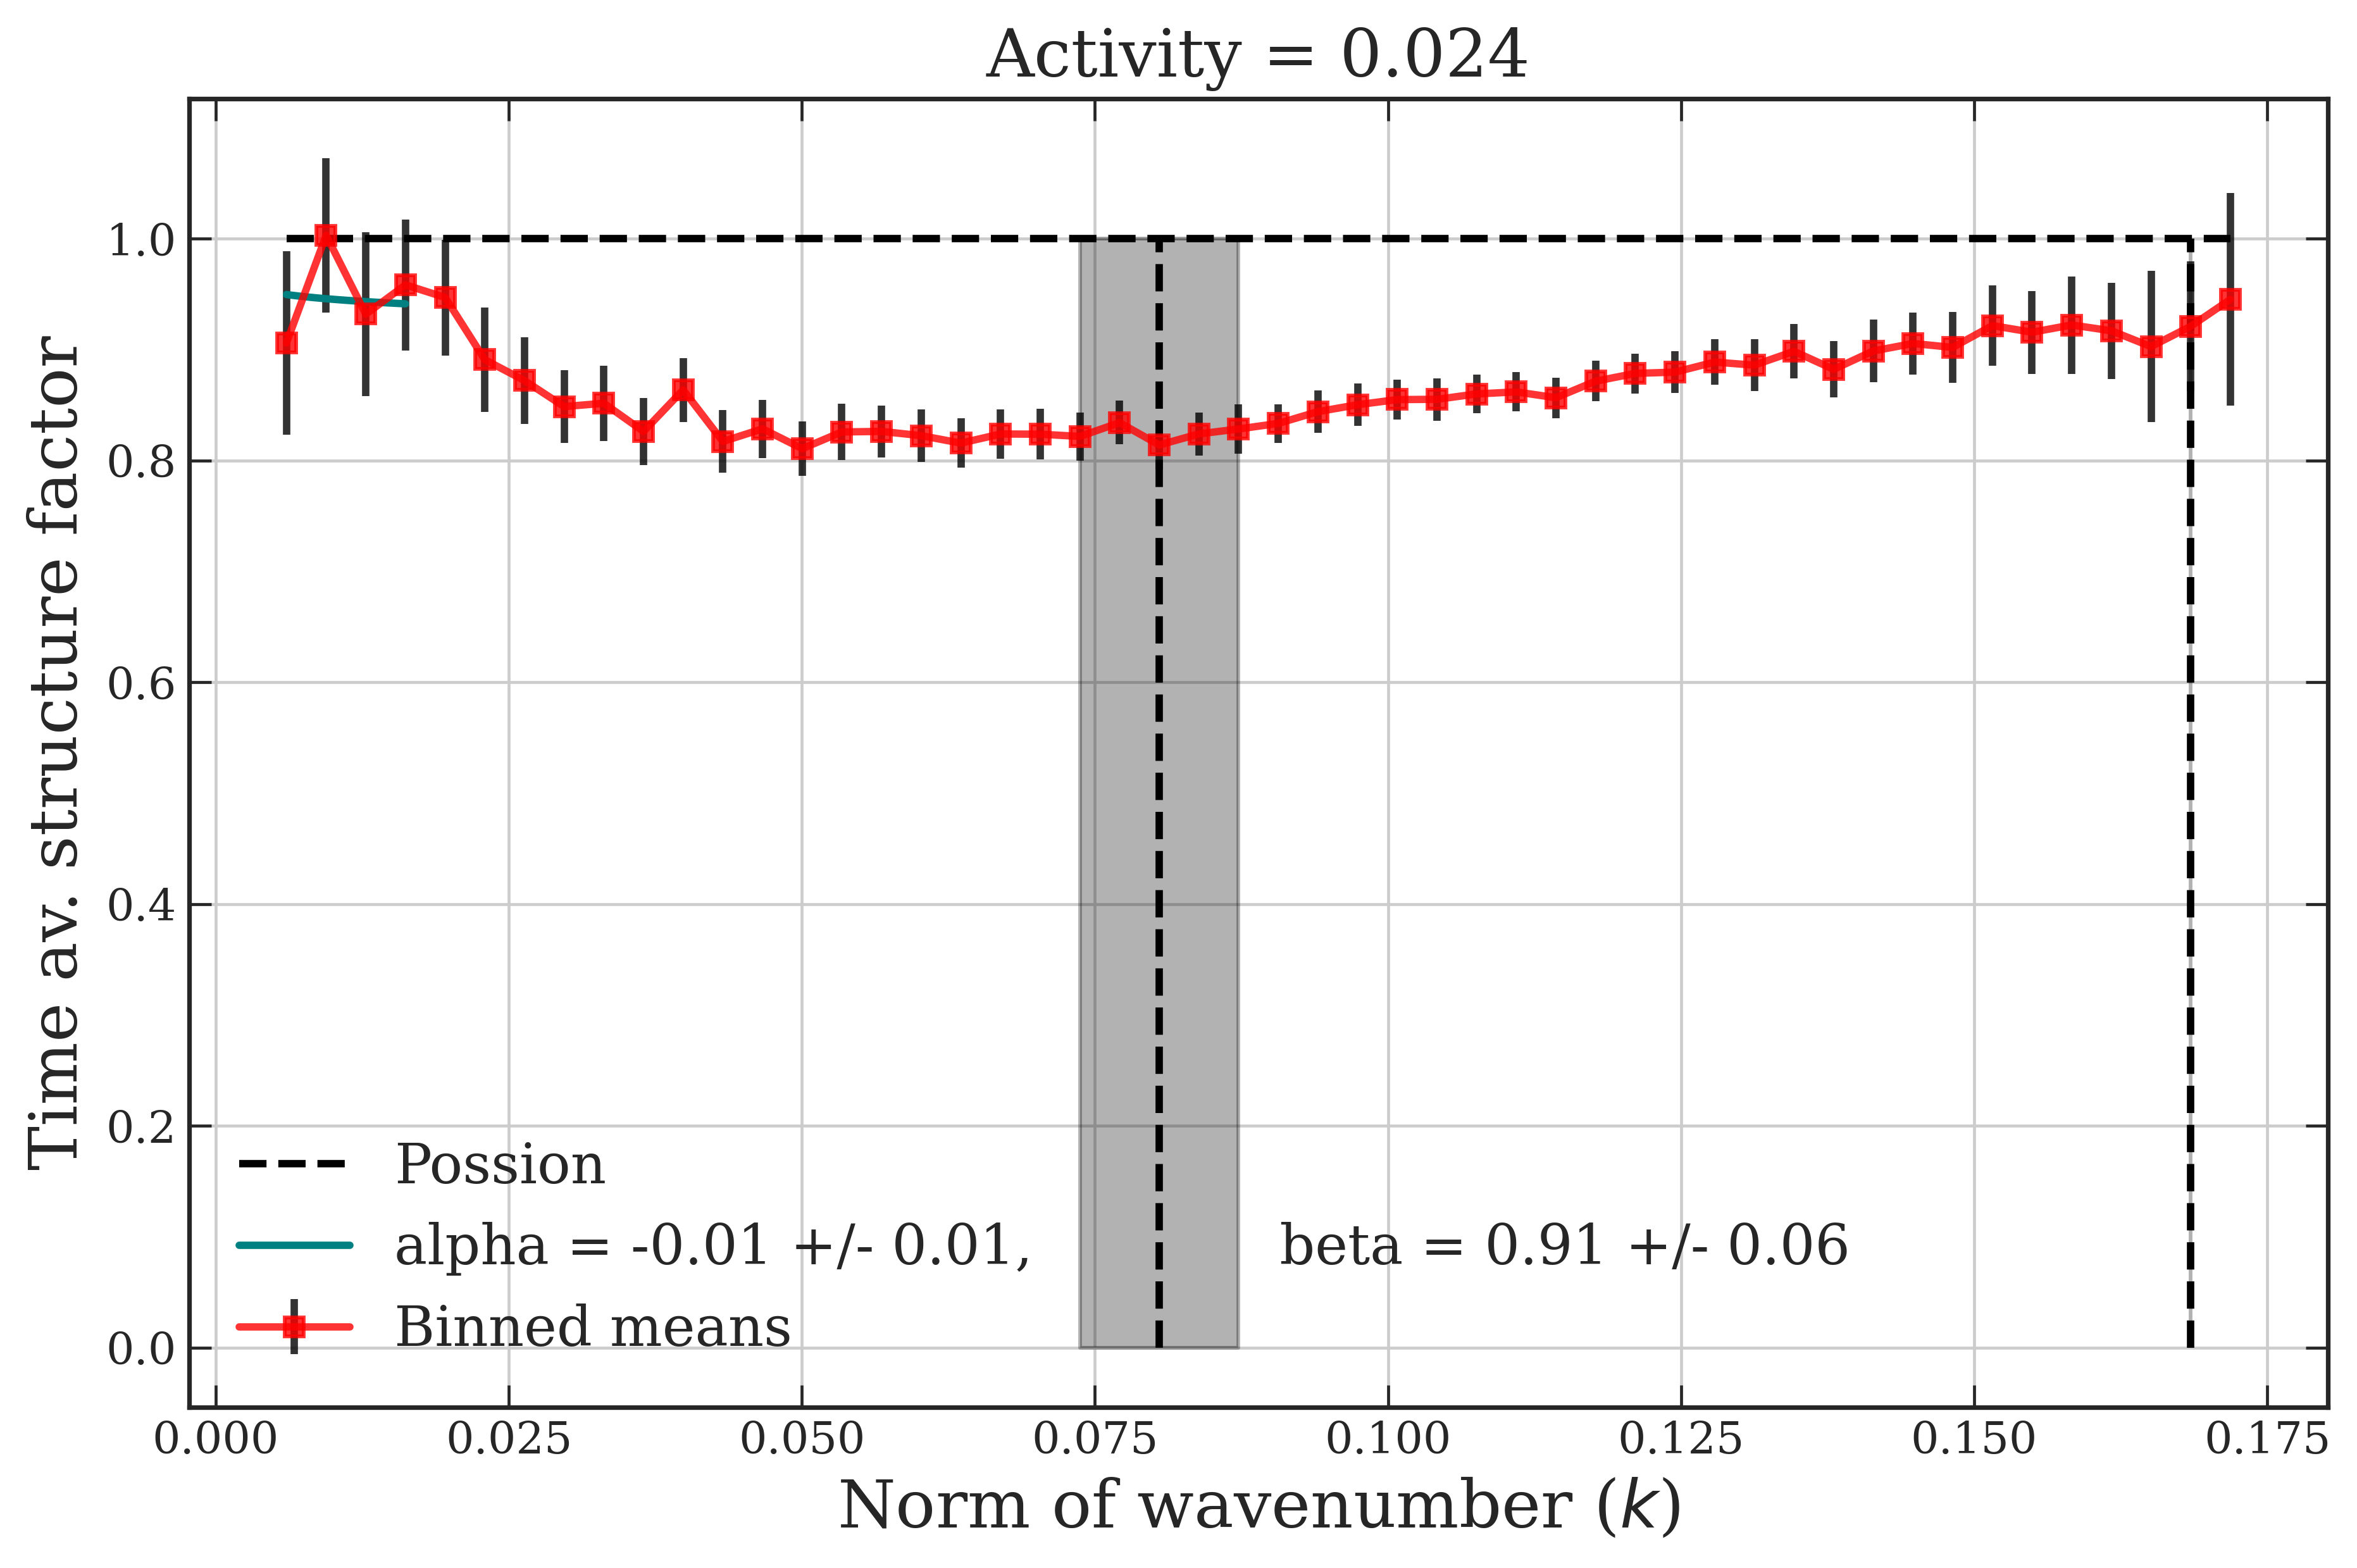

In [93]:
fit_func = lambda k, alpha, beta: np.exp(beta) * k ** (alpha)

kbins, sfac_av = ada.get_sfac(LX=LL,time_av=True)[:2]
act_list = ada.act_list[ada.LX.index(LL)]
sfac_av[:,:,-1] *= 10
fit_params_weighted7 = analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,7])
#len_scales_arr = np.nan * np.zeros((len(act_list), 3, 4))
scale_names = ['ahu', 'u', 'hu']

act_min = 0.024

act_min_idx = act_list.index(act_min)

for j, act in enumerate(act_list[act_min_idx:act_min_idx+1]):
    i = j + act_min_idx
    kmax_idx = 3
    act_idx = act_list.index(act)
   # fig, ax = plot_structure_factor(kbins, sfac_av[:,i,0], sfac_av[:, i,1], LX=LL)
    kvals = np.linspace(kbins[0], kbins[kmax_idx], 100)
    kdiff = np.diff(kbins)[0]

    for len_scale in range(3):
      #  fig.clf()
        clear_output(wait=False)
        fig, ax = plot_structure_factor(kbins, sfac_av[:,i,0], sfac_av[:, i,1], LX=LL)
        ax.plot(kvals, fit_func(kvals, *fit_params_weighted7[i,:2]),
             label = f'alpha = {fit_params_weighted7[i,0]:.2f} +/- {fit_params_weighted7[i,2]:.2f}, \
             beta = {np.exp(fit_params_weighted7[i,1]):.2f} +/- {np.exp(fit_params_weighted7[i,1])*fit_params_weighted7[i,3]:.2f}')
        
        kmin, kmax, kmin_unc, kmax_unc = len_scales_arr[i, len_scale, :]
        ax.vlines(kmin, 0, 1, color = 'k', linestyle = 'dashed')
        ax.fill_betweenx([0, 1], kmin - kmin_unc, kmin+kmin_unc, color = 'k', alpha = 0.3)
        ax.vlines(kmax, 0, 1, color = 'k', linestyle = 'dashed')
        ax.fill_betweenx([0, 1], kmax - kmax_unc, kmax+kmax_unc, color = 'k', alpha = 0.3)
    
        ax.set_title(f'Activity = {act}')
        ax.set_yscale('linear')
        ax.set_xscale('linear')
        ax.grid(True)
        ax.legend() 
        plt.show()

        ridx_ok = input('ok?:')
        ok = True if ridx_ok in ['y', ''] else False

        it = 0
        while not ok and it < 3:
            
            it += 1
            ridx_min_input = input(f'Enter min ridx+ridx_unc for {scale_names[len_scale]}: ')
            print(ridx_min_input, ridx_min_input.split('+'))
            if ridx_min_input == 'n':
                break
            else:
                ridx_min, ridx_min_unc = int(ridx_min_input.split('+')[0]), int(ridx_min_input.split('+')[1])
           

            ridx_max_input = input(f'Enter max ridx for {scale_names[len_scale]}: ')
            ridx_max, ridx_max_unc = int(ridx_max_input.split('+')[0]), int(ridx_max_input.split('+')[1])
            clear_output(wait=False)
      
            fig, ax = plot_structure_factor(kbins, sfac_av[:,i,0], sfac_av[:, i,1], LX=LL)
            ax.plot(kvals, fit_func(kvals, *fit_params_weighted7[i,:2]),
                label = f'alpha = {fit_params_weighted7[i,0]:.2f} +/- {fit_params_weighted7[i,2]:.2f}, \
                beta = {np.exp(fit_params_weighted7[i,1]):.2f} +/- {np.exp(fit_params_weighted7[i,1])*fit_params_weighted7[i,3]:.2f}')
            ax.set_title(f'Activity = {act}')
            ax.set_yscale('linear')
            ax.set_xscale('linear')
            ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.025))
            ax.grid(True)
            ax.legend() 
            ax.vlines(kbins[ridx_min], 0, 1, color = 'k', linestyle = 'dashed')
            ax.fill_betweenx([0, 1], kbins[ridx_min] - kdiff * ridx_min_unc, kbins[ridx_min] + kdiff * ridx_min_unc, color = 'k', alpha = 0.3)
            ax.vlines(kbins[ridx_max], 0, 1, color = 'k', linestyle = 'dashed')
            ax.fill_betweenx([0, 1], kbins[ridx_max] - kdiff * ridx_max_unc, kbins[ridx_max] + kdiff * ridx_max_unc, color = 'k', alpha = 0.3)
            plt.show()
            ridx_ok = input('ok?:')
            if ridx_ok in ['y', '']:
                ok = True
                len_scales_arr[i, len_scale, :] = kbins[ridx_min], kbins[ridx_max], kdiff * ridx_min_unc, kdiff * ridx_max_unc
    

In [ ]:
len_scale_arr_path = os.path.join(ad.output_main_path, 'len_scale_arr.npy')
np.save(len_scale_arr_path, len_scales_arr)

In [ ]:
fit_func = lambda k, alpha, beta: np.exp(beta) * k ** (alpha)

kbins, sfac_av = ada.get_sfac(LX=LL,time_av=True)[:2]
act_list = ada.act_list[ada.LX.index(LL)]
sfac_av[:,:,-1] *= 10
fit_params_weighted7 = analyze_sfac_time_av(kbins, sfac_av, Npoints_bounds = [3,7])
#len_scales_arr = np.nan * np.zeros((len(act_list), 3, 4))
scale_names = ['ahu', 'u', 'hu']

act_min = 0.07
act_min_idx = act_list.index(act_min)

for j, act in enumerate(act_list[act_min_idx:]):
    i = j + act_min_idx
    kmax_idx = 3
    act_idx = act_list.index(act)
   # fig, ax = plot_structure_factor(kbins, sfac_av[:,i,0], sfac_av[:, i,1], LX=LL)
    kvals = np.linspace(kbins[0], kbins[kmax_idx], 100)
    kdiff = np.diff(kbins)[0]

    for len_scale in range(3):
      #  fig.clf()
        clear_output(wait=False)
        fig, ax = plot_structure_factor(kbins, sfac_av[:,i,0], sfac_av[:, i,1], LX=LL)
        ax.plot(kvals, fit_func(kvals, *fit_params_weighted7[i,:2]),
             label = f'alpha = {fit_params_weighted7[i,0]:.2f} +/- {fit_params_weighted7[i,2]:.2f}, \
             beta = {np.exp(fit_params_weighted7[i,1]):.2f} +/- {np.exp(fit_params_weighted7[i,1])*fit_params_weighted7[i,3]:.2f}')
        ax.set_title(f'Activity = {act}')
        ax.set_yscale('linear')
        ax.set_xscale('linear')
        ax.legend() 
        plt.show()

        ok = False
        it = 0
        while not ok and it < 3:
            
            it += 1
            ridx_min_input = input(f'Enter min ridx+ridx_unc for {scale_names[len_scale]}: ')
            print(ridx_min_input, ridx_min_input.split('+'))
            if ridx_min_input == 'n':
                break
            else:
                ridx_min, ridx_min_unc = int(ridx_min_input.split('+')[0]), int(ridx_min_input.split('+')[1])
           

            ridx_max_input = input(f'Enter max ridx for {scale_names[len_scale]}: ')
            ridx_max, ridx_max_unc = int(ridx_max_input.split('+')[0]), int(ridx_max_input.split('+')[1])
            clear_output(wait=False)
      
            fig, ax = plot_structure_factor(kbins, sfac_av[:,i,0], sfac_av[:, i,1], LX=LL)
            ax.plot(kvals, fit_func(kvals, *fit_params_weighted7[i,:2]),
                label = f'alpha = {fit_params_weighted7[i,0]:.2f} +/- {fit_params_weighted7[i,2]:.2f}, \
                beta = {np.exp(fit_params_weighted7[i,1]):.2f} +/- {np.exp(fit_params_weighted7[i,1])*fit_params_weighted7[i,3]:.2f}')
            ax.set_title(f'Activity = {act}')
            ax.set_yscale('linear')
            ax.set_xscale('linear')
            ax.legend() 
            ax.vlines(kbins[ridx_min], 0, 1, color = 'k', linestyle = 'dashed')
            ax.fill_betweenx([0, 1], kbins[ridx_min] - kdiff * ridx_min_unc, kbins[ridx_min] + kdiff * ridx_min_unc, color = 'k', alpha = 0.3)
            ax.vlines(kbins[ridx_max], 0, 1, color = 'k', linestyle = 'dashed')
            ax.fill_betweenx([0, 1], kbins[ridx_max] - kdiff * ridx_max_unc, kbins[ridx_max] + kdiff * ridx_max_unc, color = 'k', alpha = 0.3)
            plt.show()
            ridx_ok = input('ok?:')
            if ridx_ok in ['y', '']:
                ok = True
                len_scales_arr[i, len_scale, :] = kbins[ridx_min], kbins[ridx_max], kdiff * ridx_min_unc, kdiff * ridx_max_unc
    


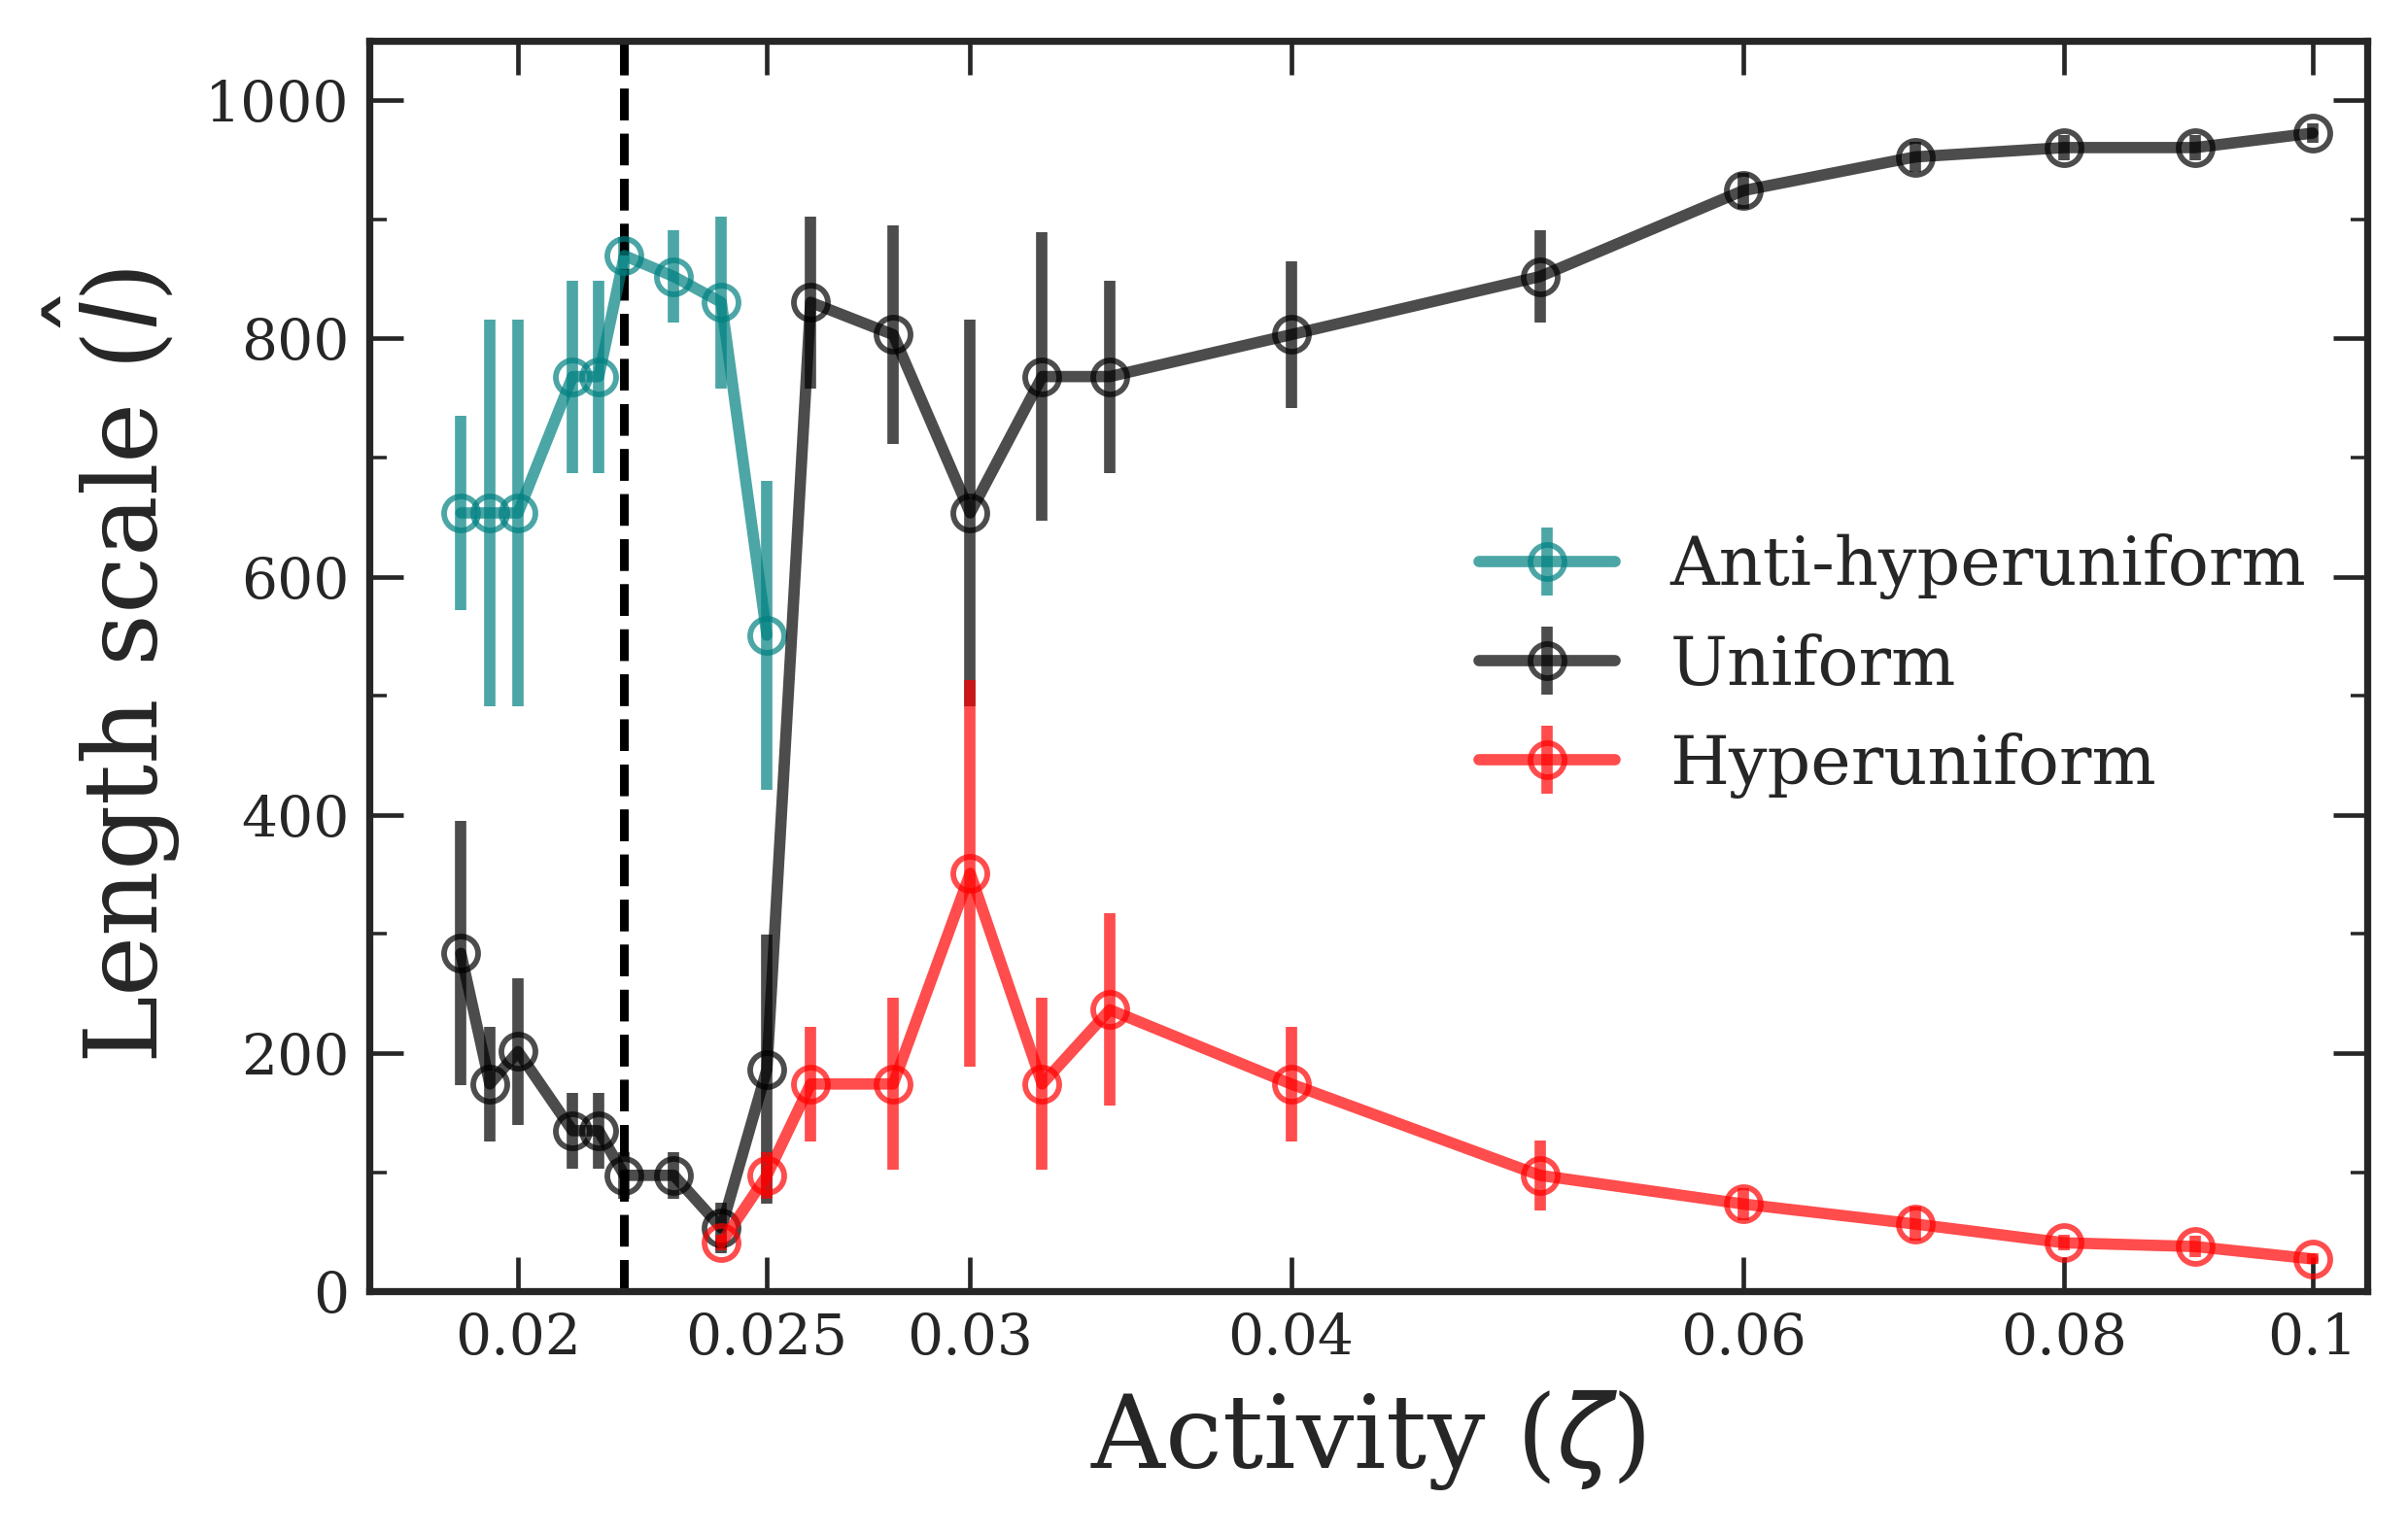

In [18]:
kbins, sfac_av = ada.get_sfac(LX=LL,time_av=True)[:2]
act_list = ada.act_list[ada.LX.index(LL)]
ratio = 4.5 / 7
w = 6
h = w * ratio
fig, ax = plt.subplots(ncols=1,figsize=(w, h))
#fig, ax = plt.subplots(figsize=(5,4))
logx = True
logy = False
len_dist_arr = 2*np.pi * (1/len_scales_arr[:,:,0] - 1/len_scales_arr[:,:,1])
unc_dist_arr = 2*np.pi * ((len_scales_arr[:,:,2] / len_scales_arr[:,:,0]**2)**2 + \
              (len_scales_arr[:,:,3] / len_scales_arr[:,:,1]**2)**2)**0.5
color_list = ['C12', 'C6', 'C7']
scale_names=['Anti-hyperuniform', 'Uniform', 'Hyperuniform']  

len_max = 2*np.pi*(1/kbins[0]-1/kbins[-1])

for i, len_scale in enumerate(scale_names):
    K=0.05
    normalizer = 1#/np.sqrt(K/np.array(act_list))
    ax.errorbar(np.log10(act_list) if logx else act_list, len_dist_arr[:,i]/normalizer, 
                yerr = unc_dist_arr[:,i]/normalizer, 
                fmt = 'o-', label = f'{len_scale}',  color=color_list[i],
                fillstyle=Line2D.fillStyles[-1],
                alpha=.7)
  #  ax.errorbar(act_list, unc_dist_arr[:,i], yerr = len_scales_arr[:,i,3], fmt = 'o-', label = f'{len_scale} max')

xticks = [0.02, 0.025, 0.030, 0.04, 0.06, 0.08,.1]
xtick_labels = [0.02, 0.025, 0.03, 0.04, 0.06, 0.08,.1]
ax.set_xticks(np.log10(xticks) if logx else xticks, xtick_labels, fontsize=10)
ax.tick_params(axis='y',which='major', labelsize=10)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(100))
ax.legend(loc='lower right', fontsize=12)
#ax.set_yscale('log')
if logy:
    ax.set_yscale('log')
    ax.set_ylim([20, 1100])
else:
  ylims = [0,1050] if type(normalizer)==int else [15,None]#[2e-3, 1.5e-1]
xlims = [np.log10(0.0175), np.log10(0.105)] if logx else [0.0175, 0.105] 
ax.set_ylim(ylims)
ax.set_xlim(xlims)
ax.vlines(np.log10(0.022) if logx else 0.022, ylims[0], ylims[1], color='k', lw=1.5, linestyle = 'dashed')
ax.vlines(np.log10(0.022) if logx else 0.022, ylims[0], ylims[1], color='k', lw=1.5, linestyle = 'dashed')
#ax.hlines(len_max, xlims[0], xlims[1], color='k', lw=1.5, linestyle = 'solid', label = 'Max length scale')
#ax.set_xscale('log')
ax.set_ylabel(ylabel = r'Length scale ($\hat{l}$)' if type(normalizer)==int else r'Length scale ($l_s / r_a$)')
ax.set_xlabel(r'Activity ($\zeta$)')
ax.legend(loc='center right', fontsize=12)
plt.tight_layout()

In [14]:
len_max = 2*np.pi*(1/kbins[0]-1/kbins[-1])
len_max, kbins[0], kbins[-1]


(1005.2775745241515, 0.006030866488320438, 0.17185800115278602)